In [99]:
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

import matplotlib.pyplot as plt
from matplotlib import style

from collections import Counter
import re
from geotext import GeoText
from wordcloud import WordCloud
from PIL import Image

import math
import string
import random
import pickle

from sklearn.cross_validation import train_test_split
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
style.use('fivethirtyeight')

In [8]:
# constants
DATA_PATH = '../data/'
JOBS_PATH = DATA_PATH + 'jobs/'
IMG_PATH = DATA_PATH + 'images/'

In [9]:
try:
    df = pd.read_pickle(JOBS_PATH + 'monster-jobs.pickle')
except FileNotFoundError:
    df = pd.read_csv(JOBS_PATH + 'monster-jobs.csv',encoding = 'ISO-8859-1')
    df.to_pickle(JOBS_PATH + 'monster-jobs.pickle')

LENGTH = len(df)

In [10]:
descriptions = df['job_description']
job_titles = df['job_title']
organization = df['organization']
sector = df['sector']

In [95]:
stop_words = set(stopwords.words('english'))
# additional stop words found in dataset
additional_stop_words = set(['Time','\x89ÛÒ','MONS LOG VARS', 'px', 'body', 'margin', 'overflow', 'visible', 'important', 'ejb header', 'color', 'font family', 'Verdana','Monster com', '','Job','OpportunityAffirmative','Opportunity', 'monster','Most', 'Date', 'Apex', 'monster.com','Monstercom','Monster com' 'MONS_LOG_VARS', 'var', 'ejb_header', 'JobID', 'Of' ])
stop_words = stop_words.union(additional_stop_words)

In [68]:
'''
returns a counter object containing all locations mined from location column
'''
def get_location_counter(column):
    all_noun_tokens = []
    location_tokens = []
    
    for elm in column:
        # tokenize location as a sentence
        # needed because some elements contain alot of text
        sent = sent_tokenize(elm)
        for sent_tok in sent:
            # tokenize sentece
            words = word_tokenize(sent_tok)
            # tag words by part of speech
            tagged = nltk.pos_tag(words)
            nouns = []
            # collect all proper nouns
            for tup in tagged:
                if tup[1] == 'NNP':
                    nouns.append(tup[0])
            all_noun_tokens.append(nouns)
    
    for token in all_noun_tokens:
        tagged = nltk.pos_tag(token)
        # create named entity from all nouns
        namedEnt = nltk.ne_chunk(tagged, binary=True)
        for ent in namedEnt:
            if(hasattr(ent, 'label') and ent.label() == 'NE'):
                location_str = ' '.join(e[0] for e in ent)
                # find combined entities such as San Jose, Las Vegas, etc
                loc = GeoText(location_str)
                if(len(loc.cities) > 0):
                    location_tokens.append(location_str.title())
    return Counter(location_tokens)

'''
creates word cloud of locations mined from dataset
focuses on cities
'''
def make_US_word_cloud(locations):
    # https://lollyjane.com/wp-content/uploads/2014/05/free-united-states-silhouette.jpg
    us_img = np.array(Image.open('../data/images/us-stencil.png'))
    
    wc = WordCloud(background_color="white", max_words=2000, mask=us_img,
                  stopwords=stop_words)
    wc.generate_from_frequencies(locations)
    wc.to_file(IMG_PATH + 'location-word-cloud.png')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [110]:
locations = df['location']
loc_counter = get_location_counter(locations)

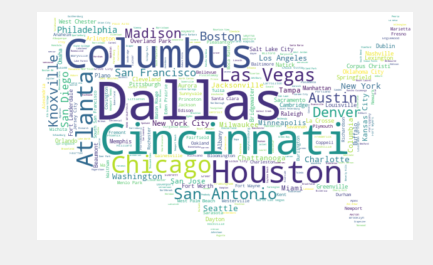

In [111]:
make_US_word_cloud(loc_counter)

In [69]:
'''
function to strip word of any location and punctuation and replaces punctuation with space 
'''
def strip_word_remove_location(word):
    # map punctuation to space
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    word = word.translate(translator)
    loc = GeoText(word)
    return word if len(loc.cities) == 0 and word != 'nan' else ''

def get_counter_object(column):
    all_tokens = []
    for row in column:
        words = word_tokenize(str(row))
        for word in words:
            word = strip_word_remove_location(word)
            word = word.strip()
            if (not word in stop_words and len(word) > 0):
                all_tokens.append(word)
    return Counter(all_tokens)

In [18]:
org_dict = df['organization'].value_counts().head(10).to_dict()
sect_dict = df['sector'].value_counts().head(10).to_dict()

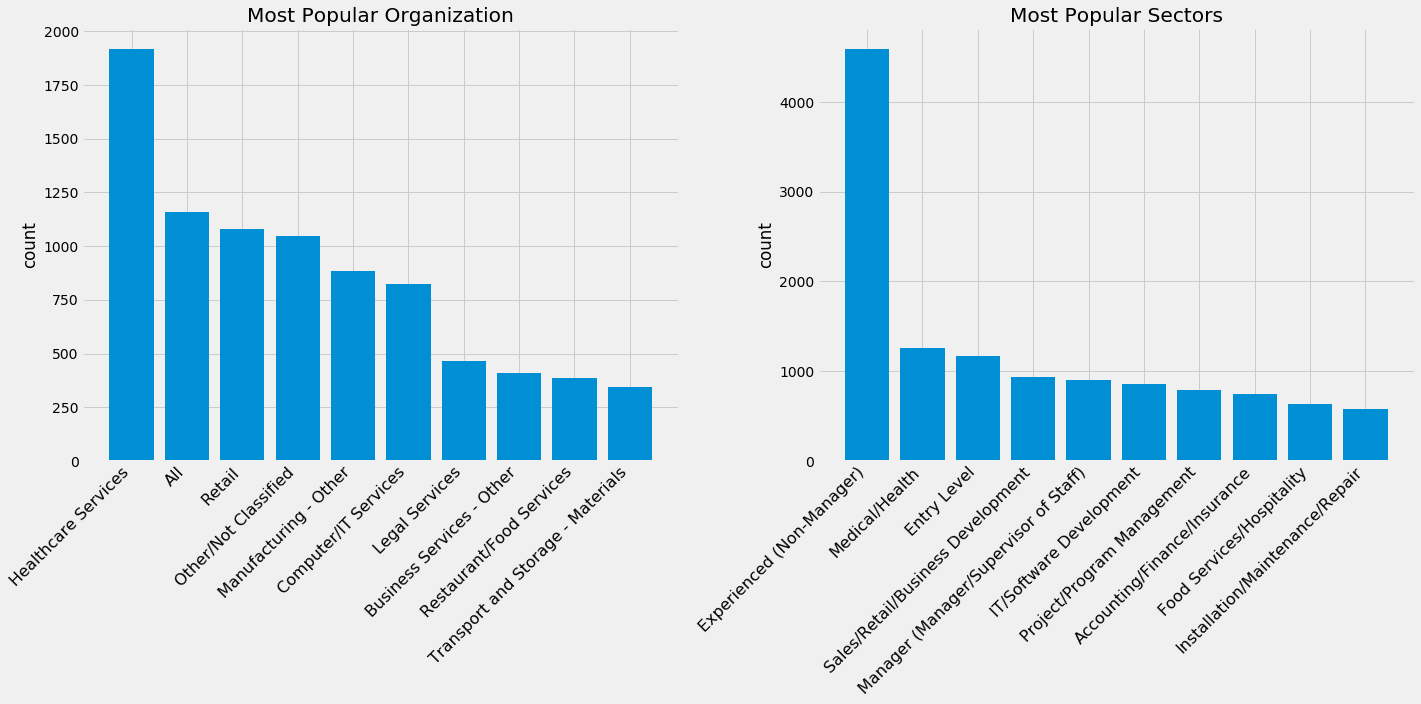

In [63]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))

ax1.bar(range(len(org_dict)),org_dict.values(), align='center')
ax1.set_xticks(range(10))
ax1.set_xticklabels(org_dict.keys(), rotation=45, fontsize=16, ha='right')
ax1.set_title('Most Popular Organization')
ax1.set_ylabel('count')

ax2.set_title('Most Popular Sectors')
ax2.set_xticks(range(10))
ax2.bar(range(len(sect_dict)),sect_dict.values(), align='center')
ax2.set_xticklabels(sect_dict.keys(), rotation=45, fontsize=16, ha='right')
ax2.set_ylabel('count')

f.tight_layout()
plt.show()

In [143]:
def generate_dict_from_tup_list(tup_list):
    return {tup[0] : tup[1] for tup in tup_list}

In [83]:
#org_counter = get_counter_object(organization).most_common(100)
#sec_counter = get_counter_object(sector).most_common(100)
#desc_counter = get_counter_object(descriptions).most_common(100)
title_counter = get_counter_object(job_titles).most_common(25)
title_counter = generate_dict_from_tup_list(title_counter)

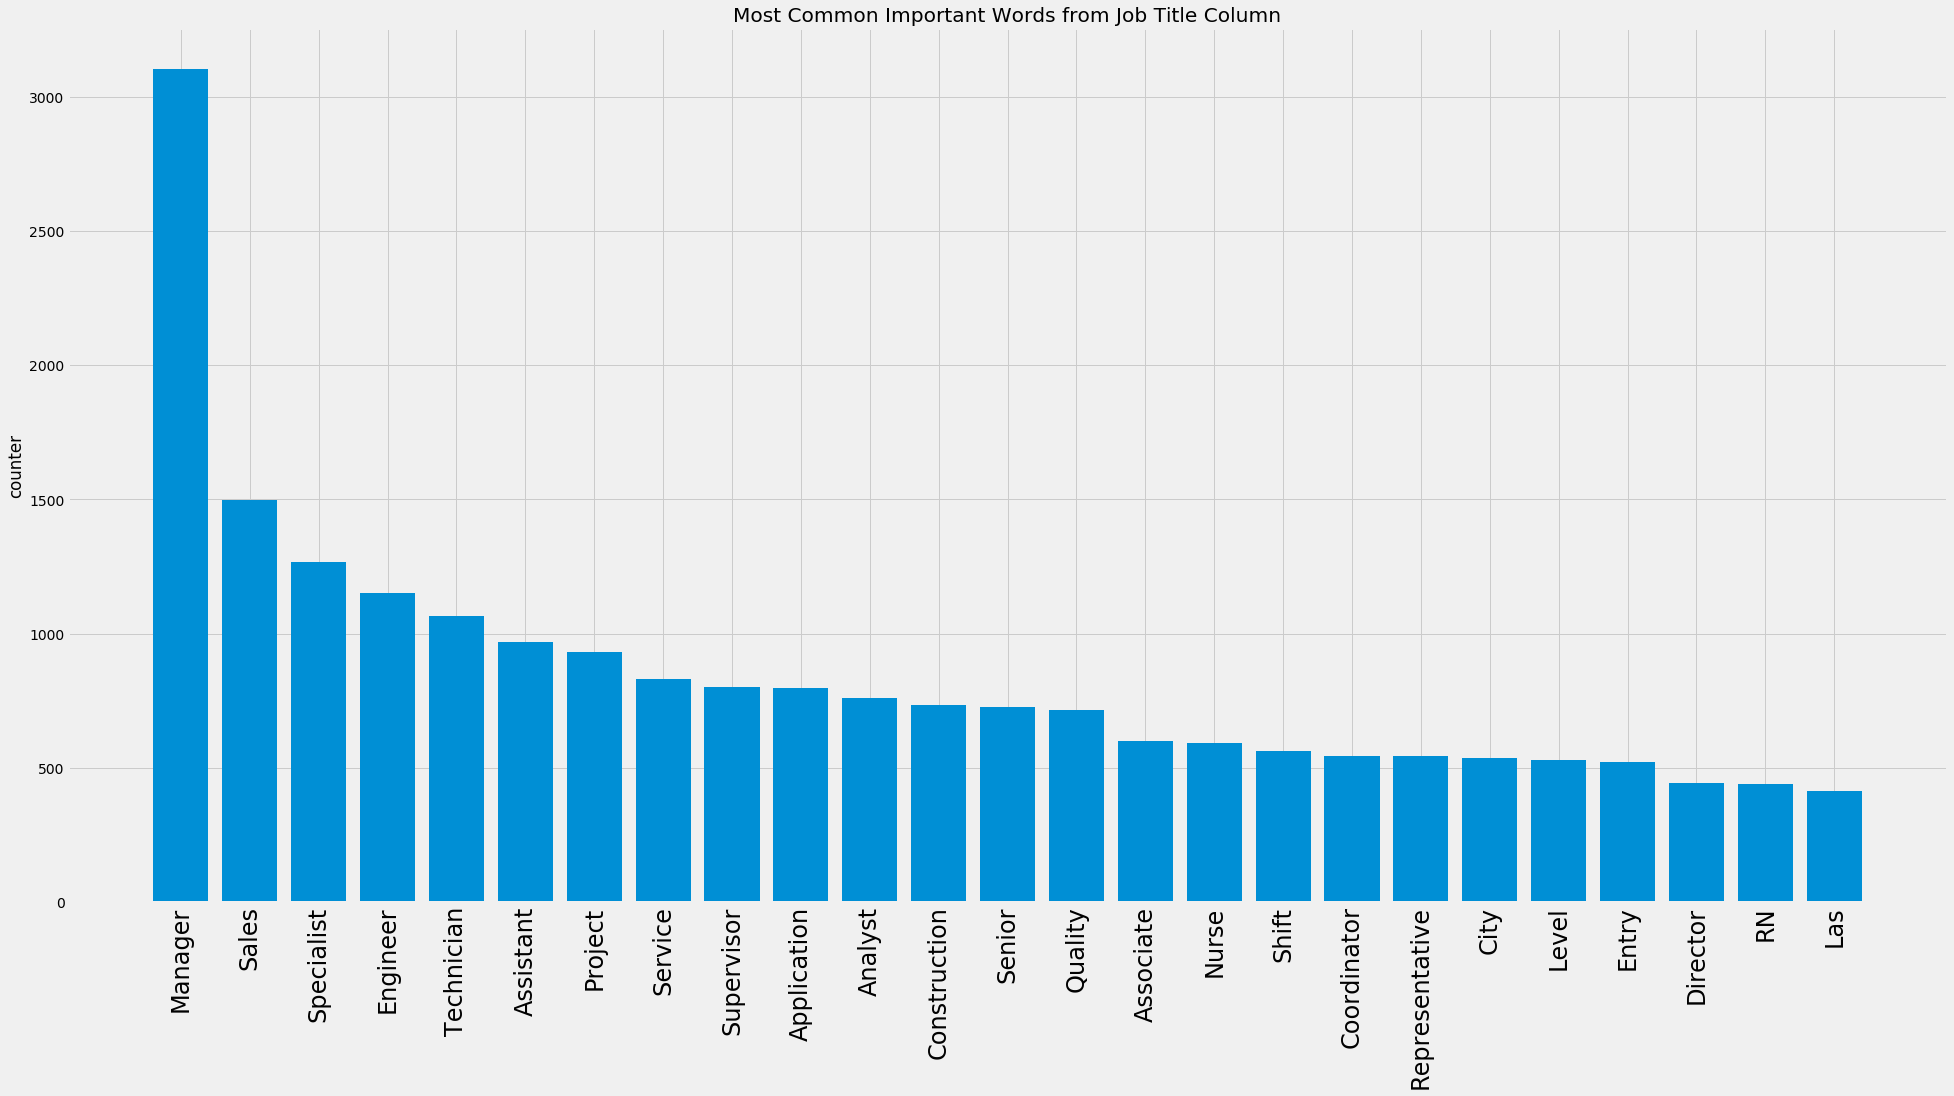

In [93]:
f, ax = plt.subplots(1,1, figsize=(30,15))
ax.bar(range(len(title_counter)), title_counter.values(), align='center')
ax.set_xticks(range(25))
ax.set_xticklabels(title_counter.keys(), rotation=90, fontsize=24, minor=False)
ax.set_ylabel('counter')
ax.set_title('Most Common Important Words from Job Title Column')
plt.show()

In [109]:
def print_top_terms(model, k_val):
    print("Top terms per cluster:")
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    for i in range(k_val):
        print("Cluster %d:" % i),
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind]),
        print
    print("\n")

In [141]:
'''
creates kmeans model given feature to cluster based on vectorizing text
'''
def generate_kmeans_model(dataframe, feature_to_be_clustered, desired_label_col, k_val):
    # vectorizer
    vectorizer = TfidfVectorizer(stop_words=stop_words)
    
    # find k most frequent values to use as labels from desired column
    top_label_values = set([key for key in dataframe[desired_label_col].value_counts().head(k_val).to_dict()])
    # filter dataframe to only consider rows with top labels
    filter_df_by_top_label = dataframe[dataframe[desired_label_col].isin(top_label_values)]
    
    # create vectorized training set
    X = vectorizer.fit_transform(filter_df_by_top_label[feature_to_be_clustered])
    
    # create model
    model = KMeans(n_clusters=k_val, init='k-means++', max_iter=100, n_init=1)
    model.fit(X)
    return model, k_val

def save_model(model, model_name):
    save_classifier = open(model_name, 'wb')
    pickle.dump(model, save_classifier)
    save_classifier.close()
    
def open_model(model_name):
    model_file = open(model_name, "rb")
    model = pickle.load(model_file)
    model_file.close()
    return model
    

In [140]:
model, k_val = generate_kmeans_model(df, 'job_title', 'organization', 5)
print_top_terms(model, k_val)

Top terms per cluster:
Cluster 0:
 san
 coordinator
 project
 antonio
 job
 manager
 francisco
 diego
 jose
 rn
Cluster 1:
 specialist
 job
 development
 resident
 alterations
 care
 payroll
 service
 billing
 dallas
Cluster 2:
 manager
 rn
 job
 nurse
 case
 registered
 quality
 assistant
 general
 development
Cluster 3:
 sales
 associate
 columbus
 part
 time
 event
 representative
 job
 specialist
 lead
Cluster 4:
 job
 supervisor
 shift
 camphill
 assistant
 nurse
 technician
 dallas
 time
 registered




In [142]:
'''
creates an encoding for input text based on most common bag of words
'''
def generate_encoded_features(bag_of_words, text):
    text = str(text)
    tokenized_text_set = set([word.lower() for word in word_tokenize(text)])
    feature_dict = {}
    for word in bag_of_words:
        word = str(word).lower()
        feature_dict[word] = (word in tokenized_text_set)
    return feature_dict

'''
generates a dataset containing encoded text as a feature and it's respective label
'''
def generate_encoded_data(dataframe,feature_col, label_col, most_common_words):
    data = []
    for _, row in dataframe.iterrows():
        data.append((generate_encoded_features(most_common_words, row[feature_col]), row[label_col]))
    return data    

In [ ]:
top_organization_values = set([key for key in df['organization'].value_counts().head(10).to_dict()])
organization_filtered_df = df[df['organization'].isin(top_organization_values)]
organization_prediction_data = generate_encoded_data(organization_filtered_df, 'job_title', 'organization',title_counter)

# shuffle data
random.shuffle(organization_prediction_data)
# 75/25 train/test split
split = int(len(organization_prediction_data) * .75)
training_set = organization_prediction_data[:split]
test_set = organization_prediction_data[split:]

In [ ]:
MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(training_set)
print("MultinomialNB accuracy percent:",nltk.classify.accuracy(MNB_classifier, test_set))


BNB_classifier = SklearnClassifier(BernoulliNB())
BNB_classifier.train(training_set)
print("BernoulliNB accuracy percent:",nltk.classify.accuracy(BNB_classifier, test_set))

In [ ]:
organization_prediction_data = generate_encoded_data(organization_filtered_df, 'sector', 'organization',sec_counter)

# shuffle data
random.shuffle(organization_prediction_data)
# 75/25 train/test split
split = int(len(organization_prediction_data) * .75)
training_set = organization_prediction_data[:split]
test_set = organization_prediction_data[split:]

In [ ]:
MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(training_set)
print("MultinomialNB accuracy percent:",nltk.classify.accuracy(MNB_classifier, test_set))


BNB_classifier = SklearnClassifier(BernoulliNB())
BNB_classifier.train(training_set)
print("BernoulliNB accuracy percent:",nltk.classify.accuracy(BNB_classifier, test_set))

In [ ]:
organization_prediction_data = generate_encoded_data(organization_filtered_df, 'job_description', 'organization',desc_counter)

# shuffle data
random.shuffle(organization_prediction_data)
# 75/25 train/test split
split = int(len(organization_prediction_data) * .75)
training_set = organization_prediction_data[:split]
test_set = organization_prediction_data[split:]

In [144]:
MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(training_set)
print("MultinomialNB accuracy percent:",nltk.classify.accuracy(MNB_classifier, test_set))


BNB_classifier = SklearnClassifier(BernoulliNB())
BNB_classifier.train(training_set)
print("BernoulliNB accuracy percent:",nltk.classify.accuracy(BNB_classifier, test_set))

NameError: name 'training_set' is not defined

In [216]:
def create_lexicon(df, feature_col):
    all_tokens = []
    for _, row in df.iterrows():
        words = word_tokenize(row[feature_col])
        for word in words:
            word = strip_word_remove_location(word)
            if (not word in stop_words):
                all_tokens.append(word.lower())
    all_tokens = [lemmatizer.lemmatize(i) for i in all_tokens]
    all_token_counts = Counter(all_tokens)
    
    lexicon = []
    
    for tok in all_token_counts:
        if (1000 > all_token_counts[tok] > 100):
            lexicon.append(tok)
    return lexicon


def sample_handling(df, feature_col, label_col, label_dict, lexicon):
    featureset = []
    for _, row in df.iterrows():
        classification_arr = [0] * len(label_dict)
        words = word_tokenize(row[feature_col].lower())
        words = [lemmatizer.lemmatize(i) for i in words]
        features = np.zeros(len(lexicon))
        
        for word in words:
            word = word.lower()
            if(word in lexicon):
                index_value = lexicon.index(word)
                features[index_value] += 1
        
        features = list(features)
        classification_arr[label_dict[row[label_col]]] = 1
        featureset.append([features, classification_arr])
    return featureset

def create_feature_sets_and_labels(df, feature_col, label_col, label_dict, test_size=.25):
    lexicon = create_lexicon(df, feature_col)
    features = []
    features += sample_handling(df, feature_col, label_col, label_dict, lexicon)
    random.shuffle(features)
    features = np.array(features)
    
    testing_size = int(test_size * len(features))
    
    '''
    quick example for why this works
        a = [] + [[[1,2,3],[1,3]]]* 5
        a = np.array(a)
        testing_size = int(.25 * len(a))
        print(testing_size)
        list(a[:,0][:-testing_size])
    '''
    train_x = list(features[:,0][:-testing_size])
    train_y = list(features[:,1][:-testing_size])
    test_x = list(features[:,0][-testing_size:])
    test_y = list(features[:,1][-testing_size:])
    
    return train_x, train_y, test_x, test_y

In [217]:
num_labels = 5
top_org_values = set([key for key in df['organization'].value_counts().head(num_labels).to_dict()])
filter_by_top_org_values = df[df['organization'].isin(top_org_values)]
top_org_values_list = list(top_org_values)
org_dict = {top_org_values_list[i]:i for i in range(len(top_org_values_list))}

In [218]:
import tensorflow as tf
train_x,train_y,test_x,test_y = create_feature_sets_and_labels(filter_by_top_org_values, 'job_title', 'organization', org_dict)
# number of nodes in each hidden layer
n_nodes_hl1 = 500
n_nodes_hl2 = 500
n_nodes_hl3 = 500

n_classes = num_labels
# go through batches of 100 features
batch_size = 100

# input data
# matrix height = height, width
x = tf.placeholder('float', [None, len(train_x[0])])
y = tf.placeholder('float')

def neural_network_model(data):
    
    hidden_1_layer = {'weights': tf.Variable(tf.random_normal([len(train_x[0]), n_nodes_hl1])),
                     'biases': tf.Variable(tf.random_normal([n_nodes_hl1]))}
    
    hidden_2_layer = {'weights': tf.Variable(tf.random_normal([n_nodes_hl1, n_nodes_hl2])),
                     'biases': tf.Variable(tf.random_normal([n_nodes_hl2]))}
    
    hidden_3_layer = {'weights': tf.Variable(tf.random_normal([n_nodes_hl2, n_nodes_hl3])),
                     'biases': tf.Variable(tf.random_normal([n_nodes_hl3]))}
    
    output_layer = {'weights': tf.Variable(tf.random_normal([n_nodes_hl3, n_classes])),
                     'biases': tf.Variable(tf.random_normal([n_classes]))}
    
    # (input_data * weights) + biases
    l1 = tf.add(tf.matmul(data, hidden_1_layer['weights']) , hidden_1_layer['biases'])
    
    # activation function
    l1 = tf.nn.relu(l1)
    
    l2 = tf.add(tf.matmul(l1, hidden_2_layer['weights']), hidden_2_layer['biases'])
    l2 = tf.nn.relu(l2)
    
    l3 = tf.add(tf.matmul(l2, hidden_3_layer['weights']) , hidden_3_layer['biases'])
    l3 = tf.nn.relu(l3)
    
    output = tf.matmul(l3, output_layer['weights']) + output_layer['biases']
    
    return output

def train_neural_network(x):
    prediction = neural_network_model(x)
    #print(prediction)
    # cross entropy with logit calculates the difference between the known label and prediction
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction,labels=y))
    # learning rate can be defined 
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    
    # cycles of feed forward and back prop
    hm_epochs = 10
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        
        for epoch in range(hm_epochs):
            epoch_loss = 0
            
            i = 0
            while i < len(train_x):
                start = i
                end = i+batch_size
                
                batch_x = np.array(train_x[start:end])
                batch_y = np.array(train_y[start:end])
                
                _, c = sess.run([optimizer, cost], feed_dict={x:batch_x, y:batch_y})
                epoch_loss += c
                i += batch_size
            print('epoch: ', epoch, ' completed out of', hm_epochs, ' loss: ' , epoch_loss)
            
        correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y,1))
        accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
        print('accuracy: ' , accuracy.eval({x:test_x, y:test_y}))

In [219]:
train_neural_network(x)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
epoch:  0  completed out of 10  loss:  70702.0845337
epoch:  1  completed out of 10  loss:  22996.9606628
epoch:  2  completed out of 10  loss:  16636.7323761
epoch:  3  completed out of 10  loss:  11871.6857834
epoch:  4  completed out of 10  loss:  9932.58831787
epoch:  5  completed out of 10  loss:  9545.75321198
epoch:  6  completed out of 10  loss:  8517.69694519
epoch:  7  completed out of 10  loss:  7820.30236816
epoch:  8  completed out of 10  loss:  7572.98288727
epoch:  9  completed out of 10  loss:  7133.75241852
accuracy:  0.488173
